# 1. 데이터 준비와 확인

In [1]:
from collections import Counter
import re
import urllib.request
import warnings

from konlpy.tag import Okt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

train_df = pd.read_table('sentiment_classification/data/ratings_train.txt')
test_df = pd.read_table('sentiment_classification/data/ratings_test.txt')

In [2]:
def make_loss_graph(history):
    history_dict = history.history
    acc, val_acc = history_dict['accuracy'], history_dict['val_accuracy']
    loss, val_loss = history_dict['loss'], history_dict['val_loss']

    epochs = range(1, len(acc)+1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [3]:
print(len(train_df), len(test_df))

150000 50000


In [4]:
train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터로더 구성과 데이터 분석 및 가공

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴



- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_df, test_df, num_words=18000, max_len=10):
    train_df = train_df.drop_duplicates(subset = ['document'])
    train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    train_df['document'] = train_df['document'].str.replace('^ +', "")
    train_df['document'] = train_df['document'].replace('', np.nan)
    train_df = train_df.dropna()

    test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_df['document'] = test_df['document'].str.replace('^ +', "")
    test_df['document'] = test_df['document'].replace('', '<UNK>')
    test_df = test_df.fillna('<UNK>')
    
    
    X_train = []
    y_train = []
    for i in range(len(train_df)):
        id_, sentence, label = train_df.iloc[i, :]
        words = tokenizer.morphs(sentence)
        words = [word for word in words if not word in stopwords]
        if words:
            X_train.append(words)
            y_train.append(label)
        

    X_test = []
    y_test = []
    for i in range(len(test_df)):
        id_, sentence, label = test_df.iloc[i, :]
        words = tokenizer.morphs(sentence)
        words = [word for word in words if not word in stopwords]
        X_test.append(words)
        y_test.append(label)
    
    words = np.concatenate(X_train).tolist()
    len_words = np.array([len(w) for w in words])
    print('문장길이')
    print('중앙값 \t평균값 \tstd \t최대값 \t최소값')
    print(np.median(len_words), '\t', np.round(np.mean(len_words), 2), '\t', np.round(np.std(len_words), 2), '\t', max(len_words), '\t', min(len_words))
    
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    index_to_word = {index:word for word, index in word_to_index.items()}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=max_len)
    
    X_test = list(map(wordlist_to_indexlist, X_test))
    X_test = keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=max_len)

    return X_train, np.array(y_train), X_test, np.array(y_test), word_to_index, index_to_word
    


In [6]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. dataset 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.


In [7]:
num_words = 18000
max_len = 25
X_train, y_train, X_test, y_test, word_to_index, index_to_word = load_data(train_df, test_df, num_words, max_len)

문장길이
중앙값 	평균값 	std 	최대값 	최소값
2.0 	 1.7 	 0.78 	 25 	 1


In [8]:
train_x = X_train[:-25000]
val_x = X_train[-25000:]
train_y = y_train[:-25000]
val_y = y_train[-25000:]

# 4. 모델 구성 및 train and evaluation

## 4-1. RNN 모델

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           1800000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,917,377
Trainable params: 1,917,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
236/236 [==============================] - 10s 32ms/step - loss: 0.5150 - accuracy: 0.7330 - val_loss: 0.3648 - val_accuracy: 0.8393
Epoch 2/5
236/236 [==============================] - 6s 27ms/step - loss: 0.3198 - accuracy: 0.8640 - val_loss: 0.3539 - val_accuracy: 0.8453
Epoch 3/5
236/236 [==============================] - 6s 27ms/step - loss: 0.2868 - accuracy

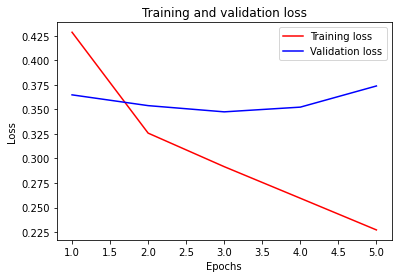

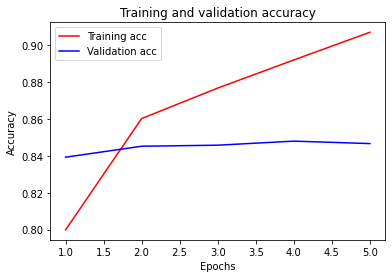

In [9]:
word_vector_dim = 100


model = keras.Sequential()
model.add(keras.layers.Embedding(num_words, word_vector_dim, input_shape=(max_len,)))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

epochs = 5

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
history = model.fit(train_x, train_y, epochs=epochs, batch_size=512, validation_data=(val_x, val_y))

results = model.evaluate(X_test,  y_test, verbose=2)
acc = round(results[1]*100, 2)
print(f'\n test set 정확도: {acc} % \n')
make_loss_graph(history)

## 4-2. 1D CNN 모델

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           1800000   
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 8)             4008      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 8)             328       
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,805,953
Trainable params: 1,805,953
Non-trainable params: 0
____________________________________________

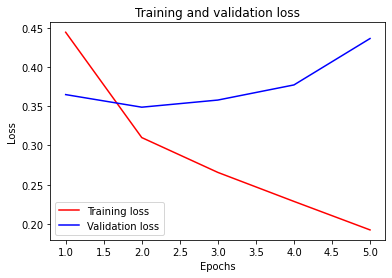

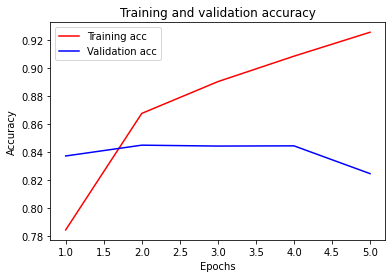

In [10]:
word_vector_dim = 100

model = keras.Sequential()
model.add(keras.layers.Embedding(num_words, word_vector_dim, input_shape=(max_len,)))
model.add(keras.layers.Conv1D(8, 5, activation='relu', strides=1, padding='same'))
model.add(keras.layers.Conv1D(8, 5, activation='relu', strides=1, padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

epochs = 5

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
history = model.fit(train_x, train_y, epochs=epochs, batch_size=512, validation_data=(val_x, val_y))

results = model.evaluate(X_test,  y_test, verbose=2)
acc = round(results[1]*100, 2)
print(f'\n test set 정확도: {acc} % \n')
make_loss_graph(history)

## 4-3. GlobalMaxPooling1D 모델

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 100)           1800000   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,800,817
Trainable params: 1,800,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
236/236 [==============================] - 4s 16ms/step - loss: 0.5948 - accuracy: 0.7331 - val_loss: 0.3720 - val_accuracy: 0.8371
Epoch 2/5
236/236 [==============================] - 4s 16ms/step - loss: 0.3298 - accuracy: 0.8606 

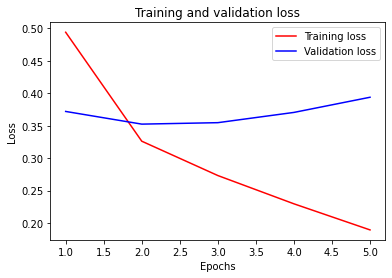

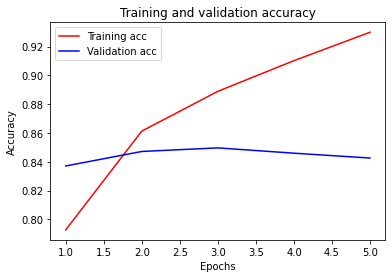

In [11]:
word_vector_dim = 100

model = keras.Sequential()
model.add(keras.layers.Embedding(num_words, word_vector_dim, input_shape=(max_len,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

epochs = 5

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
history = model.fit(train_x, train_y, epochs=epochs, batch_size=512, validation_data=(val_x, val_y))

results = model.evaluate(X_test,  y_test, verbose=2)
acc = round(results[1]*100, 2)
print(f'\n test set 정확도: {acc} % \n')
make_loss_graph(history)

# 5. 자체학습 Embedding 레이어 분석

In [12]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(18000, 100)


In [13]:
word2vec_file_path = 'sentiment_classification/data/movie_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(num_words-4, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(4, num_words):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [14]:
# !pip install python-Levenshtein

In [15]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


array([-7.71664679e-02,  5.70724159e-02, -8.85983258e-02, -2.59165708e-02,
       -8.20650235e-02, -5.80035709e-02,  2.33342052e-02, -7.45142251e-02,
       -1.01728924e-01,  4.50448282e-02, -3.59502658e-02, -2.61765830e-02,
       -7.60574862e-02, -6.78387135e-02, -4.32228111e-03,  3.63663882e-02,
       -5.51350266e-02,  7.56909028e-02, -3.79238725e-02, -4.23540268e-03,
        1.31188566e-03, -6.37513325e-02, -2.85275131e-02, -1.78831276e-02,
       -5.50426077e-03, -1.58926789e-02,  1.02244318e-04,  2.54171155e-02,
        2.29320601e-01, -1.63771883e-02, -6.90508708e-02, -6.63243085e-02,
        1.07816055e-01, -5.34924958e-03, -8.79924223e-02, -5.54034859e-02,
       -6.10937774e-02, -5.84556200e-02, -3.95407788e-02, -4.20209169e-02,
        1.40206562e-03, -9.11904499e-02, -5.04193753e-02,  7.44032785e-02,
        8.29628948e-03,  3.30725089e-02, -4.48004976e-02, -5.22113293e-02,
       -5.97766079e-02,  9.42678005e-03, -5.55595458e-02, -4.64461446e-02,
        9.84281581e-03,  

In [16]:
word_vectors.similar_by_word('재미')

[('스릴', 0.49778592586517334),
 ('던데', 0.46535763144493103),
 ('홍', 0.45615556836128235),
 ('스릴감', 0.4523535370826721),
 ('긴장감', 0.44738420844078064),
 ('건졌', 0.4471091628074646),
 ('진짜', 0.446234792470932),
 ('아빠', 0.4418526887893677),
 ('상황', 0.441236674785614),
 ('ㅇㅇㅇㅇ', 0.43377187848091125)]

# 6. 한국어 Word2Vec 임베딩 활용하여 성능개선

한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

https://fasttext.cc/docs/en/crawl-vectors.html  
아래 주석을 해제하고, 다운로드 받을 수 있습니다.

In [17]:
# from urllib import request 
# url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ko.300.bin.gz"
# savename = "sentiment_classification/data/cc.ko.300.bin.gz"
# request.urlretrieve(url, savename)

In [18]:
# import gzip
# import shutil
# with gzip.open('sentiment_classification/data/cc.ko.300.bin.gz', 'rb') as f_in:
#     with open('sentiment_classification/data/cc.ko.300.bin', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

In [19]:
from gensim import models

ko_model = models.fasttext.load_facebook_model('sentiment_classification/data/cc.ko.300.bin')
ko_model.wv.most_similar(positive=['재미'])

[('실콕스', 0.7009633779525757),
 ('통쾌함', 0.5585300922393799),
 ('쏠쏠', 0.5492354035377502),
 ('재미가', 0.5472882390022278),
 ('재미와', 0.5217501521110535),
 ('재미는', 0.5210652351379395),
 ('흥미', 0.5164767503738403),
 ('재미도', 0.5036113262176514),
 ('찾아나요', 0.48469895124435425),
 ('향하고보기는', 0.4844212532043457)]

In [20]:
word_vector_dim = 300
embedding_matrix = np.random.rand(num_words, word_vector_dim)

for i in range(4, num_words):
    if index_to_word[i] in ko_model.wv:
        embedding_matrix[i] = ko_model.wv[index_to_word[i]]

## 6-1 사전학습 임베딩 + LSTM 모델

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 300)           5400000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 5,839,553
Trainable params: 5,839,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
236/236 [==============================] - 21s 77ms/step - loss: 0.5406 - accuracy: 0.7124 - val_loss: 0.3561 - val_accuracy: 0.8458
Epoch 2/5
236/236 [==============================] - 17s 71ms/step - loss: 0.3134 - accuracy: 0.8662 - val_loss: 0.3388 - val_accuracy: 0.8506
Epoch 3/5
236/236 [==============================] - 17s 70ms/step - loss: 0.2670 - accu

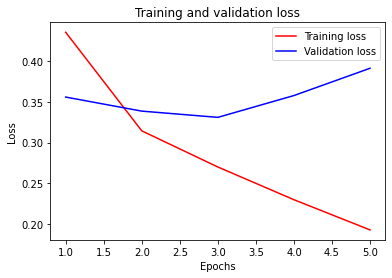

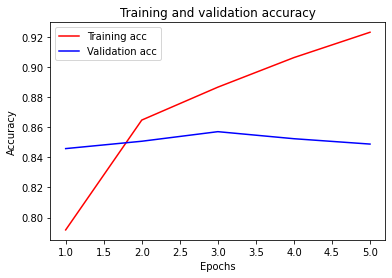

In [21]:
model = keras.Sequential()
model.add(keras.layers.Embedding(
    num_words,
    word_vector_dim,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_len,
    trainable=True)
)
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128)))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

epochs = 5

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
history = model.fit(train_x, train_y, epochs=epochs, batch_size=512, validation_data=(val_x, val_y))

results = model.evaluate(X_test,  y_test, verbose=2)
acc = round(results[1]*100, 2)
print(f'\n test set 정확도: {acc} % \n')
make_loss_graph(history)

## 6-2 사전학습 임베딩 + 1D CNN 모델

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 300)           5400000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 16)            24016     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 16)            1296      
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 401       
Total params: 5,425,713
Trainable params: 5,425,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
236/236 [==============================] - 20s 68ms/step - loss: 0.5669 - accuracy: 0.6685 - val_los

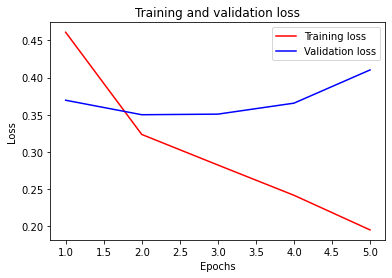

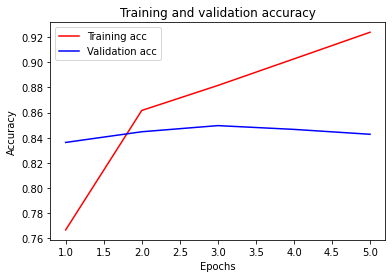

In [22]:
model = keras.Sequential()
model.add(keras.layers.Embedding(
    num_words,
    word_vector_dim,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_len,
    trainable=True)
)
model.add(keras.layers.Conv1D(16, 5, activation='relu', strides=1, padding='same'))
model.add(keras.layers.Conv1D(16, 5, activation='relu', strides=1, padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

epochs = 5

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
history = model.fit(train_x, train_y, epochs=epochs, batch_size=512, validation_data=(val_x, val_y))

results = model.evaluate(X_test,  y_test, verbose=2)
acc = round(results[1]*100, 2)
print(f'\n test set 정확도: {acc} % \n')
make_loss_graph(history)

## 6-3 사전학습 임베딩 + GlobalMaxPooling1D 모델

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 25, 300)           5400000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 2408      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 5,402,417
Trainable params: 5,402,417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
236/236 [==============================] - 11s 45ms/step - loss: 0.6772 - accuracy: 0.5979 - val_loss: 0.5114 - val_accuracy: 0.7816
Epoch 2/5
236/236 [==============================] - 12s 50ms/step - loss: 0.4561 - accuracy: 0.804

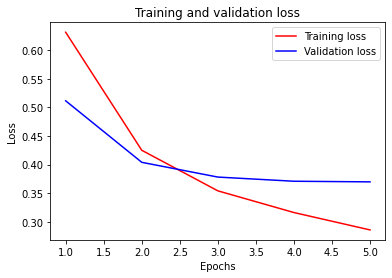

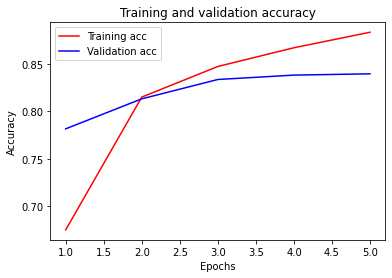

In [23]:
model = keras.Sequential()
model.add(keras.layers.Embedding(
    num_words,
    word_vector_dim,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_len,
    trainable=True)
)
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

epochs = 5

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
history = model.fit(train_x, train_y, epochs=epochs, batch_size=512, validation_data=(val_x, val_y))

results = model.evaluate(X_test,  y_test, verbose=2)
acc = round(results[1]*100, 2)
print(f'\n test set 정확도: {acc} % \n')
make_loss_graph(history)

## 6.4 사전학습 임베딩 + LSTM + CNN 1D + GlobalMaxPooling1D 모델
- Keras functional api를 활용해 LSTM, CNN 1D, ClobalMaxPooling1D을 동시에 학습시키는 모델을 작성

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 25, 300)      5400000     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 25, 300)      0           embedding_8[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 256)          439296      dropout_4[0][0]                  
____________________________________________________________________________________________

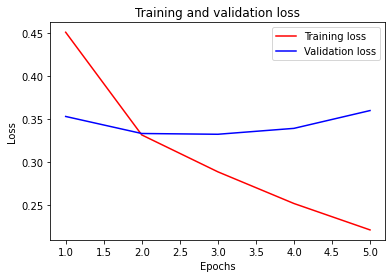

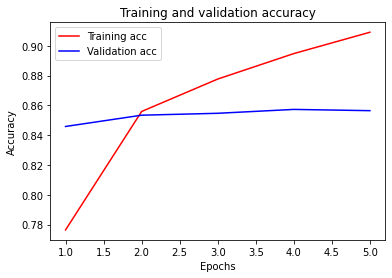

In [26]:
inputs = keras.Input(shape=(max_len, ))

embedding = keras.layers.Embedding(
    num_words,
    word_vector_dim,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_len,
    trainable=True
)(inputs)
embedding = keras.layers.Dropout(0.3)(embedding)



lstm = keras.layers.Bidirectional(keras.layers.LSTM(128))(embedding)
dense1 = keras.layers.Dense(256, activation='relu')(lstm)

dense2 = keras.layers.GlobalMaxPooling1D()(embedding)

cnn = keras.layers.Conv1D(8, 5, activation='relu', strides=1, padding='same')(embedding)
cnn = keras.layers.Conv1D(8, 5, activation='relu', strides=1, padding='same')(embedding)
dense3 = keras.layers.Flatten()(cnn)


concat = keras.layers.Concatenate(axis=-1)([dense1, dense2, dense3])
concat = keras.layers.Dropout(0.3)(concat)
output = keras.layers.Dense(1, activation='sigmoid')(concat)

model = keras.Model(inputs=inputs, outputs=output)
model.summary()

epochs = 5

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])              
history = model.fit(train_x, train_y, epochs=epochs, batch_size=512, validation_data=(val_x, val_y))

results = model.evaluate(X_test,  y_test, verbose=2)
acc = round(results[1]*100, 2)
print(f'\n test set 정확도: {acc} % \n')
make_loss_graph(history)

# 회고
- 사전 훈련 임베딩을 사용했을 때, 약 0.2%p 의 정확도 향상이 있었습니다.
- 사전 훈련 임베딩 + LSTM + CNN 1D + GlobalMaxPooling1D를 활용한 모델을 사용한 경우, 0.8%p 의 정확도 향상이 있었습니다.
- test set 기준 85.08%의 정확도를 달성했습니다.